# Model Selection & HyperParameters

### The Wisconsin breast cancer dataset

For this lesson, we will look at another sample dataset included with scikit-learn.  The cancer dataset has 30 features and a binary target of "malignant" or "benign."  This dataset is moderate sized with 569 samples.  

Our goal in this lesson is not to identify the *optimal* classifier and hyperparameters, but simply to explore how to work with the parametric space.

In [1]:
from sklearn import datasets

In [2]:
cancer = datasets.load_breast_cancer()
cancer.target_names

array(['malignant', 'benign'], dtype='<U9')

In [3]:
print(cancer.DESCR)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

## Naive classification

For now, we use K Nearest Neighbors (KNN) classification, mostly because it is easy to understand.  The general idea of KNN is simply to identify the K points that are "closest" to a test point or newly observed point, and let the plurality win.$^1$  KNN does quite well for numerous classification and regression problems.

<hr/>
<small>$^1$<i>The winner may not be a majority.  For example with 8 nearest neighbors and four classes, we might have a predicted point equally close to 2 points from each class.  The tie is broken arbitrarily by the order of the training data.  Even if we had 9 neighbors and the count of those nearby were `{A:3, B:2, C:2, D:2}`, letting A win would still be with only 1/3 of neighbors "voting" for A.</i></small> 

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, test_size = 0.2,random_state=1)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.9385964912280702

A 93% score might strike you as quite good, especially having seen much worse ones in other examples.  However, the thing we are trying to predict is literally a life or death matter, which makes the number seem less impressive.  Moreover, we have not here teased out the differences between false positives and false negatives in that mean accuracy score.  Presumably, in this domain we would rather have more false positives than false negatives because unnecessarily treatment (or unnecessary additional testing) is less bad than a missed diagnosis.

In a later lesson we look at metrics in more detail. For this lesson, we will only look at this model `.score()` method as our optimization goal.

## Exploring one hyperparameter

The most obvious hyperparameter for KNN classification is the number of neighbors used.  Many aspects of the data—from number of samples, to number of dimensions, to multi-modality in univariate distribution of features—can greatly affect the "right" answer.  Moreover, if we really want to arrive at the best classification, we should look at scaling issues that will be glossed over here but discussed in a later lesson on feature engineering.

In [6]:
import pandas as pd

scores = []
for k in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    scores.append(knn.score(X_test, y_test))
    
pd.Series(scores, index=range(1,40), name="Score")

1     0.921053
2     0.921053
3     0.921053
4     0.903509
5     0.938596
6     0.947368
7     0.938596
8     0.947368
9     0.929825
10    0.929825
11    0.929825
12    0.929825
13    0.921053
14    0.921053
15    0.921053
16    0.921053
17    0.912281
18    0.921053
19    0.912281
20    0.912281
21    0.912281
22    0.912281
23    0.903509
24    0.912281
25    0.903509
26    0.903509
27    0.903509
28    0.903509
29    0.903509
30    0.903509
31    0.903509
32    0.903509
33    0.903509
34    0.903509
35    0.894737
36    0.903509
37    0.894737
38    0.894737
39    0.903509
Name: Score, dtype: float64

It is easier to see a pattern if we visualize the trend.

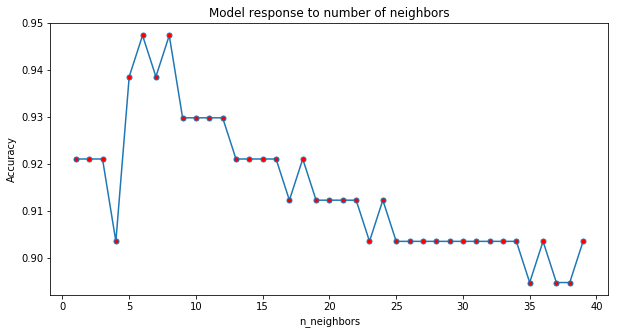

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(1, 40), scores,marker='o', markerfacecolor='red', markersize=5)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('Model response to number of neighbors');

## Exploring many hyperparameters

While `n_neighbors` is the most obvious hyperparameter, others can significantly affect the accuracy (or other metrics) as well.  All scikit-learn models have default values for their hyperparameters, but how good those choices are is very domain specific.

The additional hyperparameters of interest to KNN are `weights` and `metric`.  There are a few other hyperparameters, but those are used for performance considerations not for fundamental behavior of trained models.

By default, `weight` is `"uniform"` meaning that it simply gives one "vote" to each of the closest neighbors.  But `"distance"` is quite plausible and weights each such neighbor by the inverse of distance (with cutoffs for only K neighbors considered nonetheless).

By default, `metric` is `"minkowski"` which a generalization of Pythagorean distance to higher dimensions.  But `"manhattan"` distance is also often useful; it measure the "city blocks" to get from point to point (i.e. the sum of the distance in each direction).  Other are available and occasionally better choices.

| identifier | distance function
|------------|----------------------
| euclidean  | $$ \sqrt{\vphantom{\int}}{\sum (x-y)^2} $$ 
| manhattan  | $$ \sum{|x-y|} $$
| chebyshev  | $$ \max {\Big\{x-y\Big\}} $$
| minkowski  | $$ \sum{\big(|x-y|^p\big)^{1/p}} $$
| wminkowski | $$ \Big({\sum |w \cdot (x-y)|^p}\Big)^{1/p} $$
| seuclidean | $$ \sqrt{\vphantom{\int}}{\sum \frac{(x-y)^2}{V}} $$
| mahalanobis| $$ \sqrt{(x-y)^{'} \cdot V^{-1} \cdot (x-y)} $$


Let us try combining a couple of these hyperparameters in the same search.

In [8]:
import numpy as np

metrics = ['minkowski', 'manhattan', 'euclidean', 'chebyshev']
K = range(1, 18, 2)
scores = np.empty((len(metrics),len(K)))

for x, k in enumerate(K):
    for y, metric in enumerate(metrics):
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train, y_train)
        score = knn.score(X_test, y_test)
        scores[y, x] = score 

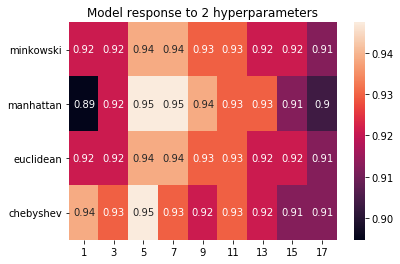

In [9]:
import seaborn as sns
ax = sns.heatmap(scores, 
                 annot=True, 
                 xticklabels=K,
                 yticklabels=metrics,
                 )
ax.set_title('Model response to 2 hyperparameters');

## GridSearchCV

So far, so good.  It would not *too* hard to keep track of the best model discovered within the inner loop.  And any Python programmer could construct more nested loops to search over 3, or 4, or 5, different hyperparameters.  

We could store all the scores in a parameter grid of N dimensions.  

Maybe while we are at it, it would be nice to remember the training and scoring times different hyperparameters take. 

It could be useful to allow for different scoring metrics to be performed within the nested search of hyperparameters.  Or actually perform multiple different scoring functions that may inform the quality of hyperparameter sets differently.

We might also want our code to perform more robust and configurable train/test split strategies.

But really, it is much easier to take the `GridSearchCV` function from scikit-learn that does all of this for us and is well-tested to avoid any pitfalls, bugs, or edge cases we might overlook.

In [10]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_neighbors': range(1, 18, 2),
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'manhattan', 'euclidean', 'chebyshev']
             }

grid =  GridSearchCV(KNeighborsClassifier(), parameters)
# Best fit over cross-product of parameter space, cross-validated
model = grid.fit(cancer.data, cancer.target)
model

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 18, 2), 'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'manhattan', 'euclidean', 'chebyshev']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Identifying the best hyperparameters

One additional nice detail of `GridSearchCV` is that by default once a best set of hyperparameters is identified, the model is refit against the entire dataset rather than only the training split.  This can improve accuracy while avoiding overfitting in the initial hyperparameter choice.

The object delivered in an attribute—but also usable directly as the grid search model object itself—reflects this improved refitting (if the argument `refit` is kept as the default `True` value).

In [11]:
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')
print(model.best_score_)

{'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'uniform'} 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform') 

0.9314586994727593


In [12]:
best_model = model.best_estimator_
model.predict(cancer.data)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

### Examining the search space

Some the information collected about the search is times taken for steps.  Given a search across a large, multi-dimensional, hyperparameter space can require many combinations, the fitting can take a considerable time. `KNeighborsClassifier` was chosen for this lesson in part because it is a very fast model.

Moreover, while KNN performs pretty much equally quickly across a range of hyperparameters, that is definitely **not true** of many other models.  In some cases, a hyperparameter choses among different algorithms with very different performance characteristics.  In others, a hyperparameter chooses among threshhold type values that can greatly affect convergence rates or other computational details.  Being able to know not only that this combination of hyperparameters has better *accuracy*, but also what the relative *performance* of each is, can be imporant.

In [13]:
(pd.DataFrame(grid.cv_results_)
   .set_index('rank_test_score')
   .sort_index()
)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
rank_test_score,,,,,,,,,,,,,,,,,,
1,0.000833,0.000111,0.002209,0.000165,euclidean,9,uniform,"{'metric': 'euclidean', 'n_neighbors': 9, 'wei...",0.900000,0.952632,0.941799,0.931459,0.022708,0.955145,0.926121,0.947368,0.942878,0.012267
1,0.000776,0.000254,0.002346,0.000097,euclidean,11,uniform,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.900000,0.947368,0.947090,0.931459,0.022274,0.952507,0.920844,0.942105,0.938485,0.013177
1,0.000805,0.000075,0.002185,0.000089,minkowski,9,uniform,"{'metric': 'minkowski', 'n_neighbors': 9, 'wei...",0.900000,0.952632,0.941799,0.931459,0.022708,0.955145,0.926121,0.947368,0.942878,0.012267
1,0.000753,0.000153,0.002594,0.000234,minkowski,11,uniform,"{'metric': 'minkowski', 'n_neighbors': 11, 'we...",0.900000,0.947368,0.947090,0.931459,0.022274,0.952507,0.920844,0.942105,0.938485,0.013177
5,0.000775,0.000035,0.002549,0.000096,manhattan,17,distance,"{'metric': 'manhattan', 'n_neighbors': 17, 'we...",0.884211,0.947368,0.957672,0.929701,0.032482,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.000681,0.000022,0.002288,0.000210,manhattan,11,uniform,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.889474,0.952632,0.947090,0.929701,0.028572,0.955145,0.931398,0.944737,0.943760,0.009719
5,0.000713,0.000171,0.002599,0.000192,manhattan,13,uniform,"{'metric': 'manhattan', 'n_neighbors': 13, 'we...",0.884211,0.952632,0.952381,0.929701,0.032209,0.947230,0.926121,0.942105,0.938485,0.008989
5,0.000730,0.000159,0.002412,0.000115,manhattan,15,uniform,"{'metric': 'manhattan', 'n_neighbors': 15, 'we...",0.884211,0.952632,0.952381,0.929701,0.032209,0.944591,0.926121,0.944737,0.938483,0.008741
5,0.000718,0.000109,0.002661,0.000138,manhattan,15,distance,"{'metric': 'manhattan', 'n_neighbors': 15, 'we...",0.884211,0.947368,0.957672,0.929701,0.032482,1.000000,1.000000,1.000000,1.000000,0.000000
